In [1]:
import pandas as pd
import numpy as np
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec, Phrases
from gensim.parsing.preprocessing import STOPWORDS as stop_words
from gensim.utils import simple_preprocess
from sklearn.feature_extraction import text
from nltk.stem.lancaster import LancasterStemmer

In [2]:
# this is each review cleaned for Doc2Vec. It is df_with_mins with only 'id' and 'textb'
cleaned_reviews_df = pd.read_pickle('cleaned_reviews_df.pkl')

In [3]:
# load df with beer/brewery data and create a lookup dictionary
df_joined = pd.read_pickle('joined_text_df.pkl')

In [4]:
lookup_df = df_joined[['id', 'brewery_id', 'name', 'city', 'state', 'country', 'brewery_name']]
lookup_df['id'] = lookup_df['id'].astype(str)
lookup_dict = lookup_df.set_index('id').to_dict(orient='index')

//anaconda3/envs/sklearn-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [214]:
letters = list('abcdefghijklmnopqrstuvwxyz')
numbers = list('0123456789')
words = ['oz', 'ml', 'pour', 'poured', 'bottle', 'can', 'ounce',\
         'bomber', 'botttle', 'stubby', 'ouncer', 'pouring', 'growler', 'snifter',\
         'tulip', 'bottled', 'brewery', 'pint', 'glass', 'cap', 'cork'] # ADD MORE
stop_words = stop_words.union(set(letters)).union(set(numbers)).union(set(words))
my_stop_words = text.ENGLISH_STOP_WORDS.union(stop_words)

def tag_docs(docs):
    results = docs.apply(lambda r: TaggedDocument(words=preprocessor(r['text']), tags=[str(r['id'])]), axis=1)
    return results.tolist()
def stem_tag_docs(docs):
    ls = LancasterStemmer()
    results = docs.apply(lambda r: TaggedDocument(words=preprocessor_and_stem(r['text']), tags=[str(r['id'])]), axis=1)
    return results.tolist()

def preprocessor(text):
    # uses gensim simple_preprocess and then removes stop words
    simple = simple_preprocess(text)
    result = [word for word in simple if not word in my_stop_words]
    return result
def preprocessor_and_stem(text):
    # uses gensim simple_preprocess and then removes stop words
    simple = simple_preprocess(text)
    result = [ls.stem(word) for word in simple if not word in my_stop_words]
#     print('stemmed')
    return result

In [20]:
cleaned_sub = cleaned_reviews_df[:100]

In [25]:
# cleaned_text = cleaned_reviews_df[:50]
ls = LancasterStemmer()
tagged_stem_docs = stem_tag_docs(cleaned_reviews_df)
# tagged_test[0]

In [26]:
# process reviews, turn into list of TaggedDocument objects, with beer id as tag
tagged_docs = tag_docs(cleaned_reviews_df)

In [28]:
## Use format like this 

model = Doc2Vec(dm=0, dbow_words=1, min_count=4, negative=3,
                hs=0, sample=1e-4, window=5, size=100, workers=8)

model.build_vocab(tagged_docs, progress_per = 100)

//anaconda3/envs/sklearn-env/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [29]:
from gensim.models.callbacks import CallbackAny2Vec
class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        print("Epoch #{} start".format(self.epoch))

    def on_epoch_end(self, model):
        print("Epoch #{} end".format(self.epoch))
        self.epoch += 1
        
# this is the above but trying it to return a dict
def location_filter(ranked_beers, state, city, n):

    located_brewery = {}
    # state = 'CA'
    # city = 'Los Angeles'
    counter = 0

    for beer in ranked_beers:
        if counter < n:
            dict_state = lookup_dict[beer[0]]['state']
            dict_city = lookup_dict[beer[0]]['city']
            brewery_id = lookup_dict[beer[0]]['brewery_id']
            brewery_name = lookup_dict[beer[0]]['brewery_name']
            beer_name = lookup_dict[beer[0]]['name']
            if (dict_state == state) and (dict_city == city):
        #             print(beer_breweries_lookup[beer[0]])
#                 print(beer[0])
                if brewery_id in located_brewery:
                    continue
                else:  
                    located_brewery[brewery_id] = (brewery_name, beer[0], beer_name)
                counter += 1
    return located_brewery

In [30]:
epoch_logger = EpochLogger()
model.train(tagged_docs, total_examples=model.corpus_count, epochs=1, callbacks=[epoch_logger])

Epoch #0 start
Epoch #0 end


In [118]:
vec = model['sour']
d2v_test = model.docvecs.most_similar([vec], topn=5000)
location_filter(d2v_test, 'WA', 'Seattle', 6)

{36949: ('Holy Mountain Brewing Company', '188999', 'The Hart'),
 28192: ('Urban Family Brewing Co.', '249057', 'Delicious Ambiguity'),
 20680: ('Fremont Brewing Company', '85085', 'The Lamb'),
 700: ('Elysian Brewing Company', '2027', 'Saison Elysee'),
 29693: ("Reuben's Brews", '187302', 'Gose'),
 17005: ('Two Beers Brewing Co.', '55833', 'Sodo Brown')}

In [125]:
model.save('epoch1-vs100')

# STEMMED MODEL

In [215]:
# cleaned_text = cleaned_reviews_df[:50]
ls = LancasterStemmer()
tagged_stem_docs = stem_tag_docs(cleaned_reviews_df)

## Use format like this 

stem_model = Doc2Vec(dm=0, dbow_words=1, min_count=4, negative=3,
                hs=0, sample=1e-4, window=5, size=100, workers=8)

stem_model.build_vocab(tagged_stem_docs)
epoch_logger = EpochLogger()
stem_model.train(tagged_stem_docs, total_examples=stem_model.corpus_count, epochs=5, callbacks=[epoch_logger])

//anaconda3/envs/sklearn-env/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end


In [245]:
def get_recs_from_wordvec(model, keyword, topn, state, city, n_recs, stem=True):
    if stem == True:
        ls = LancasterStemmer()
        vec = model[ls.stem(keyword)]
        tags = model.docvecs.most_similar([vec], topn=topn)
    else:
        vec = model[keyword]
        tags = model.docvecs.most_similar([vec], topn=topn)
    return location_filter(tags, state, city, n_recs)

In [253]:
get_recs_from_wordvec(stem_model, 'night', 5000, 'WA', 'Seattle', 4, stem = True)

{20680: ('Fremont Brewing Company', '317221', 'Stone Squirrel'),
 19764: ('Schooner Exact Brewing Company', '56171', 'King Street Brown Ale'),
 17005: ('Two Beers Brewing Co.', '113530', 'Fall Line (Alta Series)'),
 4378: ('Georgetown Brewing Company', '39024', 'Georgetown Porter')}

In [219]:
# stem_model.save('stem_model_1')

In [216]:
# increasing window size

stem_model_window = Doc2Vec(dm=0, dbow_words=1, min_count=4, negative=3,
                hs=0, sample=1e-4, window=7, size=100, workers=8)

stem_model_window.build_vocab(tagged_stem_docs)
epoch_logger = EpochLogger()
stem_model_window.train(tagged_stem_docs, total_examples=stem_model_window.corpus_count, epochs=5, callbacks=[epoch_logger])

//anaconda3/envs/sklearn-env/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end


In [220]:
stem_model_window.save('stem_model_window7')

### Stemmed with vector size of 200

In [217]:
# cleaned_text = cleaned_reviews_df[:50]
# ls = LancasterStemmer()
# tagged_stem_docs = stem_tag_docs(cleaned_reviews_df)

## Use format like this 

stem_model2 = Doc2Vec(dm=0, dbow_words=1, min_count=4, negative=3,
                hs=0, sample=1e-4, window=5, size=200, workers=8)

stem_model2.build_vocab(tagged_stem_docs)
epoch_logger = EpochLogger()
stem_model2.train(tagged_stem_docs, total_examples=stem_model2.corpus_count, epochs=5, callbacks=[epoch_logger])

Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end


In [221]:
stem_model2.save('stem_model_vs200')

### Non-stemmed model

In [218]:
model = Doc2Vec(dm=0, dbow_words=1, min_count=4, negative=3,
                hs=0, sample=1e-4, window=5, size=200, workers=8)

model.build_vocab(tagged_docs, progress_per = 100)
epoch_logger = EpochLogger()
model.train(tagged_docs, total_examples=model.corpus_count, epochs=5, callbacks=[epoch_logger])

Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end


In [222]:
model.save('non-stem-vs200')

### Infer vector

In [110]:
# will be able to let someone add many words? this might be a WIP
test = model.infer_vector('sour'.split())
test_recs = model.docvecs.most_similar([test],topn=20000)
location_filter(test_recs, 'WA', 'Seattle', 6)

### Plotting

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [157]:
def get_doc_tags_from_keyword(keyword, topn):
    vec = model[keyword]
    keywords_and_sim = model.docvecs.most_similar([vec], topn=topn)
    doc_tags = []
    for i in keywords_and_sim:
        doc_tags.append(i[0])
    return doc_tags

def tsne_df(doc_tags):
    tsne = TSNE(n_components=2)
    vectors = model[doc_tags]
    vec_tsne = tsne.fit_transform(vectors)
    df = pd.DataFrame(vec_tsne, index=doc_tags, columns=['x', 'y'])
    return df

In [42]:
doc_tags = list(model.docvecs.doctags.keys())
X = model[doc_tags]

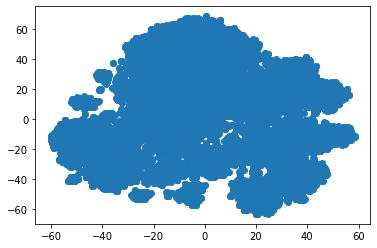

In [150]:
plt.scatter(df['x'], df['y'])

In [58]:
model.docvecs.vectors

array([], shape=(0, 100), dtype=float64)

In [ ]:
sour_tags = get_doc_tags_from_keyword('sour', 100)  
sour_df = tsne_df(sour_tags)

In [ ]:
doc_tags = list(model.docvecs.doctags.keys())
X = model[doc_tags]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y'])

In [195]:
sour_tags = get_doc_tags_from_keyword('sour', 5000)  
sour_df = tsne_df(sour_tags)

In [193]:
hop_tags = get_doc_tags_from_keyword('hop', 5000)  
hop_df = tsne_df(hop_tags)

In [194]:
dank_tags = get_doc_tags_from_keyword('dank', 5000)  
dank_df = tsne_df(dank_tags)

In [188]:
stout_tags = get_doc_tags_from_keyword('stout', 5000)  
stout_df = tsne_df(stout_tags)

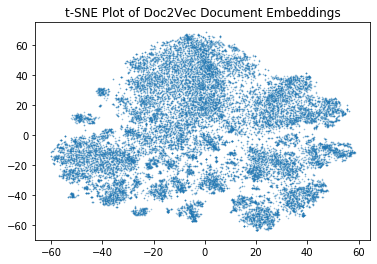

<Figure size 432x288 with 0 Axes>

In [212]:
fig = plt.plot()
plt.scatter(df['x'], df['y'],s=0.4, alpha = 0.4)
# plt.scatter(sour_df['x'], sour_df['y'], c='red', s=0.4, alpha=0.5)
# plt.scatter(hop_df['x'], hop_df['y'], c='green', s=1, alpha=0.5)
# plt.scatter(dank_df['x'], dank_df['y'], c='yellow', s=1, alpha=0.5)
# plt.scatter(stout_df['x'], stout_df['y'], c='black', s=1, alpha=0.5)
plt.title('t-SNE Plot of Doc2Vec Document Embeddings')
plt.show()
plt.savefig('t-SNE of all docs', quality=90)

# Testing Models from Thursday Night

In [257]:
models = [model, stem_model]

In [270]:
# ok this is hard to do
def test_multiple_models(models,keyword,topn, state, city, n_recs, stem = True):
    for i in range(len(models)):
        output = []
        output.append([str(model[i]), get_recs_from_wordvec(model[i], keyword, topn, state, city, n_recs, stem)])
        return output

In [269]:
# test_multiple_models(models,'night', 5000, 'WA', 'Seattle', 4);

In [273]:
get_recs_from_wordvec(stem_model, 'night', 5000, 'MI', 'Sawyer', 4, stem = True)

{25937: ('Greenbush Brewing Company', '96890', 'Barrel Aged Dystopia')}